In [1]:
import mxnet as mx
import gluonnlp as nlp

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sacremoses
import time
from tqdm.notebook import tqdm

# Local Libraries
import nmt
import dataprocessor
import utils
import nmt.transformer_hparams

# Seeds for reproducibility
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

# CPU setup
# ctx = mx.cpu()
# Single GPU setup
ctx = mx.gpu(0)

[nltk_data] Downloading package punkt to /home/andreto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andreto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andreto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# IWSLT2015 Dataset (Train, Validation and Test)

# Dataset Parameters
src_lang, tgt_lang = "vi", "en"
src_max_len, tgt_max_len = 50, 50

iwslt_train_text = nlp.data.IWSLT2015("train",
                                      src_lang=src_lang,
                                      tgt_lang=tgt_lang)

iwslt_val_text   = nlp.data.IWSLT2015("val",
                                      src_lang=src_lang,
                                      tgt_lang=tgt_lang)

iwslt_test_text  = nlp.data.IWSLT2015("test",
                                      src_lang=src_lang,
                                      tgt_lang=tgt_lang)


iwslt_src_vocab = iwslt_train_text.src_vocab
iwslt_tgt_vocab = iwslt_train_text.tgt_vocab

/home/andreto/.local/lib/python3.7/site-packages/gluonnlp/vocab/vocab.py:591: UserWarning: Detected a corrupted index in the deserialize vocabulary. For versions before GluonNLP v0.7 the index is corrupted by specifying the same token for different special purposes, for example eos_token == padding_token. Deserializing the vocabulary nevertheless.
  'Detected a corrupted index in the deserialize vocabulary. '


In [3]:
print("Length of train set:", len(iwslt_train_text))
print("Length of val set  :", len(iwslt_val_text))
print("Length of test set :", len(iwslt_test_text))

Length of train set: 133166
Length of val set  : 1553
Length of test set : 1268


In [4]:
# Dataset processing: clipping, tokenizing, indexing and adding of EOS (src/tgt) / BOS (tgt)
iwslt_train_processed = iwslt_train_text.transform(
    dataprocessor.TrainValDataTransform(
        iwslt_src_vocab,
        iwslt_tgt_vocab,
        src_max_len,
        tgt_max_len),
    lazy=False)

iwslt_val_processed   = iwslt_val_text.transform(
    dataprocessor.TrainValDataTransform(
        iwslt_src_vocab,
        iwslt_tgt_vocab,
        src_max_len,
        tgt_max_len),
    lazy=False)

iwslt_test_processed  = iwslt_test_text.transform(
    dataprocessor.TrainValDataTransform(
        iwslt_src_vocab,
        iwslt_tgt_vocab,
        src_max_len,
        tgt_max_len),
    lazy=False)

In [5]:
# Target Sequences (Val, Test)
fetch_tgt_sentence = lambda src, tgt: tgt.split()
val_tgt_sentences = list(iwslt_val_text.transform(fetch_tgt_sentence))
test_tgt_sentences = list(iwslt_test_text.transform(fetch_tgt_sentence))

In [6]:
# Create Gluon Datasets
# Not needed for training, as training data will be sharded later
iwslt_train_transformed = iwslt_train_processed.transform(
    lambda src, tgt: (src, tgt, len(src), len(tgt)),
    lazy=False)

iwslt_val_dataset = mx.gluon.data.SimpleDataset(
    [(ele[0], ele[1], len(ele[0]), len(ele[1]),i) for i, ele in enumerate(iwslt_val_processed)])

iwslt_test_dataset = mx.gluon.data.SimpleDataset(
    [(ele[0], ele[1], len(ele[0]), len(ele[1]), i) for i, ele in enumerate(iwslt_test_processed)])

In [7]:
# Hyperparameters for Dataloaders and Training
hparams = nmt.transformer_hparams

In [8]:
# Create Gluon Samplers and DataLoaders

# Helper function for lengths
def get_data_lengths(dataset):
    get_lengths = lambda *args: (args[2], args[3])
    return list(dataset.transform(get_lengths))

# Bucket scheme
bucket_scheme = nlp.data.ExpWidthBucket(bucket_len_step=1.2)

iwslt_train_lengths = get_data_lengths(iwslt_train_transformed)
iwslt_val_lengths = get_data_lengths(iwslt_val_dataset)
iwslt_test_lengths = get_data_lengths(iwslt_test_dataset)

train_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'))

test_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack())

target_val_lengths = list(map(lambda x: x[-1], iwslt_val_lengths))
target_test_lengths = list(map(lambda x: x[-1], iwslt_test_lengths))

train_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=iwslt_train_lengths,
    batch_size=hparams.batch_size,
    num_buckets=hparams.num_buckets,
    ratio=0,
    shuffle=True,
    use_average_length=False,
    num_shards=0,
    bucket_scheme=bucket_scheme)
    
train_data_loader = nlp.data.ShardedDataLoader(
    iwslt_train_transformed,
    batch_sampler=train_batch_sampler,
    batchify_fn=train_batchify_fn,
    num_workers=8)

val_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=iwslt_val_lengths,
    batch_size=hparams.test_batch_size,
    num_buckets=hparams.num_buckets,
    ratio=0,
    shuffle=False,
    use_average_length=False,
    bucket_scheme=bucket_scheme)

val_data_loader = mx.gluon.data.DataLoader(
    iwslt_val_dataset,
    batch_sampler=val_batch_sampler,
    batchify_fn=test_batchify_fn,
    num_workers=8)

test_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=iwslt_test_lengths,
    batch_size=hparams.test_batch_size,
    num_buckets=hparams.num_buckets,
    ratio=0,
    shuffle=False,
    use_average_length=False,
    bucket_scheme=bucket_scheme)

test_data_loader = mx.gluon.data.DataLoader(
    iwslt_test_dataset,
    batch_sampler=test_batch_sampler,
    batchify_fn=test_batchify_fn,
    num_workers=8)

/home/andreto/.local/lib/python3.7/site-packages/gluonnlp/data/batchify/batchify.py:235: UserWarning: Padding value is not given and will be set automatically to 0 in data.batchify.Pad(). Please check whether this is intended (e.g. value of padding index in the vocabulary).
  'Padding value is not given and will be set automatically to 0 '


In [9]:
# Transformer Model
transformer_encoder, transformer_decoder, transformer_one_step_ahead_decoder = nlp.model.transformer.get_transformer_encoder_decoder(
    hidden_size=hparams.num_hidden,
    dropout=hparams.dropout,
    num_layers=hparams.num_layers)

transformer_model = nlp.model.translation.NMTModel(
    src_vocab=iwslt_src_vocab,
    tgt_vocab=iwslt_tgt_vocab,
    encoder=transformer_encoder,
    decoder=transformer_decoder,
    one_step_ahead_decoder=transformer_one_step_ahead_decoder,
    #embed_size=hparams.num_hidden,
    embed_size=hparams.num_units,
    prefix='transformer_')

transformer_model.initialize(init=mx.init.Xavier(magnitude=1.0), ctx=ctx)
static_alloc = True
transformer_model.hybridize(static_alloc=static_alloc)

In [10]:
# Translator (using model defined above)
transformer_translator = nmt.translation.BeamSearchTranslator(
    model=transformer_model,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(
        alpha=hparams.lp_alpha,
        K=hparams.lp_k),
    max_length=150)

In [11]:
# Loss function
loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(static_alloc=static_alloc)

In [12]:
# Let's train
trainer = mx.gluon.Trainer(transformer_model.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

best_valid_bleu = 0.0

train_losses = []
valid_losses = []
valid_bleus  = []
valid_perplexities = []

for epoch_id in tqdm(range(hparams.epochs)):

    log_loss = 0
    log_denom = 0
    log_avg_gnorm = 0
    log_wc = 0
    log_start_time = time.time()
    
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(train_data_loader)):
        
        src_seq = src_seq.as_in_context(ctx)
        tgt_seq = tgt_seq.as_in_context(ctx)
        src_valid_length = src_valid_length.as_in_context(ctx)
        tgt_valid_length = tgt_valid_length.as_in_context(ctx)
        
        with mx.autograd.record():
            out, _ = transformer_model(
                src_seq,
                tgt_seq[:, :-1],
                src_valid_length,
                tgt_valid_length - 1)

            loss = loss_function(out, tgt_seq[:, 1:], tgt_valid_length - 1).mean()
            loss = loss * (tgt_seq.shape[1] - 1)
            log_loss += loss * tgt_seq.shape[0]
            log_denom += (tgt_valid_length - 1).sum()
            loss = loss / (tgt_valid_length - 1).mean()
            loss.backward()
        
        grads = [p.grad(ctx) for p in transformer_model.collect_params().values() if p.grad_req != 'null']
        gnorm = mx.gluon.utils.clip_global_norm(grads, hparams.clip)
        trainer.step(1)
        
        src_wc = src_valid_length.sum().asscalar()
        tgt_wc = (tgt_valid_length - 1).sum().asscalar()
        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_avg_gnorm += gnorm
        log_wc += src_wc + tgt_wc
        
        train_loss = log_loss / log_denom
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, gnorm={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(train_data_loader),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 log_avg_gnorm / hparams.log_interval,
                                 wps / 1000, log_wc / 1000))
            
            log_start_time = time.time()
            log_loss = 0
            log_denom = 0
            log_avg_gnorm = 0
            log_wc = 0
            
    train_losses.append(train_loss)
    
    valid_loss, valid_translation_out = nmt.utils.evaluate(
        val_data_loader,
        transformer_model,
        transformer_translator,
        loss_function,
        iwslt_tgt_vocab,
        ctx)

    valid_perplexity = np.exp(valid_loss)
    valid_perplexities.append(valid_perplexity)
    
    valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu([val_tgt_sentences], valid_translation_out)
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, valid_loss, valid_perplexity, valid_bleu_score * 100))
    
    valid_losses.append(valid_loss)
    valid_bleus.append(valid_bleu_score * 100)

    if valid_bleu_score > best_valid_bleu:
        best_valid_bleu = valid_bleu_score
        print("Save best parameters to {}".format(hparams.file_name))
        transformer_model.save_parameters(hparams.file_name)
    
    if epoch_id + 1 >= (hparams.epochs * 2) // 3:
        new_lr = trainer.learning_rate * hparams.lr_update_factor
        print("Learning rate change to {}".format(new_lr))
        trainer.set_learning_rate(new_lr)

if os.path.exists(hparams.file_name):
    transformer_model.load_parameters(hparams.file_name)

valid_loss, valid_translation_out = nmt.utils.evaluate(
    val_data_loader,
    transformer_model,
    transformer_translator,
    loss_function,
    iwslt_tgt_vocab,
    ctx)

valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu([val_tgt_sentences], valid_translation_out)
print("Best model valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
      .format(valid_loss, np.exp(valid_loss), valid_bleu_score * 100))

test_loss, test_translation_out = nmt.utils.evaluate(
    test_data_loader,
    transformer_model,
    transformer_translator,
    loss_function,
    iwslt_tgt_vocab,
    ctx)

test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu([test_tgt_sentences], test_translation_out)
print("Best model test Loss={:.4f}, test ppl={:.4f}, test bleu={:.2f}"
      .format(test_loss, np.exp(test_loss), test_bleu_score * 100))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1043 [00:00<?, ?it/s]

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-08-08 22:56:32.620 ip-172-31-28-47:20349 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-08-08 22:56:32.650 ip-172-31-28-47:20349 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
[Epoch 0 Batch 100/1043] loss=6.6870, ppl=801.8875, gnorm=1.9236, throughput=43.60K wps, wc=606.57K
[Epoch 0 Batch 200/1043] loss=5.4197, ppl=225.8099, gnorm=0.9394, throughput=48.56K wps, wc=584.18K
[Epoch 0 Batch 300/1043] loss=5.0296, ppl=152.8729, gnorm=0.8303, throughput=49.52K wps, wc=592.78K
[Epoch 0 Batch 400/1043] loss=4.7467, ppl=115.2045, gnorm=0.8531, throug

  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 0] valid Loss=3.5775, valid ppl=35.7836, valid bleu=9.33
Save best parameters to transformer_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 1 Batch 100/1043] loss=3.8630, ppl=47.6095, gnorm=1.0429, throughput=48.10K wps, wc=593.66K
[Epoch 1 Batch 200/1043] loss=3.7978, ppl=44.6027, gnorm=0.9675, throughput=50.88K wps, wc=631.62K
[Epoch 1 Batch 300/1043] loss=3.6807, ppl=39.6735, gnorm=0.9657, throughput=48.98K wps, wc=599.65K
[Epoch 1 Batch 400/1043] loss=3.6023, ppl=36.6839, gnorm=1.0160, throughput=48.83K wps, wc=585.70K
[Epoch 1 Batch 500/1043] loss=3.4896, ppl=32.7719, gnorm=0.9897, throughput=47.73K wps, wc=567.14K
[Epoch 1 Batch 600/1043] loss=3.4151, ppl=30.4203, gnorm=1.0818, throughput=46.11K wps, wc=521.63K
[Epoch 1 Batch 700/1043] loss=3.4741, ppl=32.2676, gnorm=1.0520, throughput=49.11K wps, wc=591.94K
[Epoch 1 Batch 800/1043] loss=3.3850, ppl=29.5175, gnorm=1.0678, throughput=48.43K wps, wc=563.74K
[Epoch 1 Batch 900/1043] loss=3.2859, ppl=26.7327, gnorm=1.0028, throughput=48.42K wps, wc=578.06K
[Epoch 1 Batch 1000/1043] loss=3.1916, ppl=24.3276, gnorm=1.0941, throughput=46.25K wps, wc=523.53K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 1] valid Loss=2.9981, valid ppl=20.0465, valid bleu=13.46
Save best parameters to transformer_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 2 Batch 100/1043] loss=3.1064, ppl=22.3404, gnorm=1.1275, throughput=46.54K wps, wc=542.87K
[Epoch 2 Batch 200/1043] loss=3.0738, ppl=21.6234, gnorm=1.0778, throughput=48.16K wps, wc=575.69K
[Epoch 2 Batch 300/1043] loss=3.0571, ppl=21.2666, gnorm=1.0968, throughput=48.55K wps, wc=568.29K
[Epoch 2 Batch 400/1043] loss=3.0399, ppl=20.9025, gnorm=1.1491, throughput=48.36K wps, wc=578.89K
[Epoch 2 Batch 500/1043] loss=2.9916, ppl=19.9183, gnorm=1.0910, throughput=48.94K wps, wc=590.93K
[Epoch 2 Batch 600/1043] loss=3.0027, ppl=20.1389, gnorm=1.1949, throughput=47.98K wps, wc=561.47K
[Epoch 2 Batch 700/1043] loss=3.0141, ppl=20.3702, gnorm=1.0724, throughput=49.85K wps, wc=624.59K
[Epoch 2 Batch 800/1043] loss=2.8789, ppl=17.7943, gnorm=1.1270, throughput=48.03K wps, wc=564.54K
[Epoch 2 Batch 900/1043] loss=2.8979, ppl=18.1364, gnorm=1.1399, throughput=48.17K wps, wc=583.36K
[Epoch 2 Batch 1000/1043] loss=2.7895, ppl=16.2726, gnorm=1.1427, throughput=46.43K wps, wc=528.11K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 2] valid Loss=2.6874, valid ppl=14.6928, valid bleu=16.81
Save best parameters to transformer_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 3 Batch 100/1043] loss=2.7784, ppl=16.0936, gnorm=1.1090, throughput=49.12K wps, wc=630.11K
[Epoch 3 Batch 200/1043] loss=2.6908, ppl=14.7441, gnorm=1.1922, throughput=48.61K wps, wc=572.70K
[Epoch 3 Batch 300/1043] loss=2.7246, ppl=15.2510, gnorm=1.1676, throughput=49.63K wps, wc=598.93K
[Epoch 3 Batch 400/1043] loss=2.5905, ppl=13.3366, gnorm=1.1893, throughput=47.14K wps, wc=537.22K
[Epoch 3 Batch 500/1043] loss=2.5551, ppl=12.8731, gnorm=1.1572, throughput=46.96K wps, wc=529.51K
[Epoch 3 Batch 600/1043] loss=2.6594, ppl=14.2881, gnorm=1.1848, throughput=49.94K wps, wc=610.71K
[Epoch 3 Batch 700/1043] loss=2.5482, ppl=12.7846, gnorm=1.2013, throughput=46.92K wps, wc=519.76K
[Epoch 3 Batch 800/1043] loss=2.5236, ppl=12.4739, gnorm=1.1941, throughput=46.47K wps, wc=539.30K
[Epoch 3 Batch 900/1043] loss=2.5651, ppl=13.0014, gnorm=1.1855, throughput=48.52K wps, wc=581.69K
[Epoch 3 Batch 1000/1043] loss=2.5939, ppl=13.3813, gnorm=1.1799, throughput=48.76K wps, wc=569.12K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 3] valid Loss=2.4974, valid ppl=12.1510, valid bleu=18.91
Save best parameters to transformer_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 4 Batch 100/1043] loss=2.3756, ppl=10.7580, gnorm=1.1260, throughput=46.91K wps, wc=568.46K
[Epoch 4 Batch 200/1043] loss=2.3661, ppl=10.6558, gnorm=1.1954, throughput=47.53K wps, wc=542.90K
[Epoch 4 Batch 300/1043] loss=2.3854, ppl=10.8636, gnorm=1.1910, throughput=48.00K wps, wc=555.44K
[Epoch 4 Batch 400/1043] loss=2.3975, ppl=10.9959, gnorm=1.2449, throughput=47.59K wps, wc=543.93K
[Epoch 4 Batch 500/1043] loss=2.4004, ppl=11.0281, gnorm=1.1847, throughput=49.12K wps, wc=579.34K
[Epoch 4 Batch 600/1043] loss=2.4021, ppl=11.0464, gnorm=1.2112, throughput=49.62K wps, wc=601.62K
[Epoch 4 Batch 700/1043] loss=2.4148, ppl=11.1874, gnorm=1.1833, throughput=49.22K wps, wc=597.87K
[Epoch 4 Batch 800/1043] loss=2.2778, ppl=9.7556, gnorm=1.2159, throughput=45.84K wps, wc=507.35K
[Epoch 4 Batch 900/1043] loss=2.4309, ppl=11.3688, gnorm=1.1694, throughput=50.34K wps, wc=624.02K
[Epoch 4 Batch 1000/1043] loss=2.3849, ppl=10.8582, gnorm=1.2861, throughput=49.08K wps, wc=580.31K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 4] valid Loss=2.4042, valid ppl=11.0693, valid bleu=19.88
Save best parameters to transformer_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 5 Batch 100/1043] loss=2.1342, ppl=8.4501, gnorm=1.1882, throughput=45.63K wps, wc=529.43K
[Epoch 5 Batch 200/1043] loss=2.2589, ppl=9.5726, gnorm=1.1642, throughput=49.71K wps, wc=611.54K
[Epoch 5 Batch 300/1043] loss=2.2200, ppl=9.2072, gnorm=1.2218, throughput=48.79K wps, wc=582.88K
[Epoch 5 Batch 400/1043] loss=2.2155, ppl=9.1660, gnorm=1.2263, throughput=47.83K wps, wc=556.31K
[Epoch 5 Batch 500/1043] loss=2.0454, ppl=7.7319, gnorm=1.2464, throughput=44.34K wps, wc=472.55K
[Epoch 5 Batch 600/1043] loss=2.2318, ppl=9.3169, gnorm=1.1917, throughput=48.90K wps, wc=586.79K
[Epoch 5 Batch 700/1043] loss=2.2003, ppl=9.0280, gnorm=1.2521, throughput=48.08K wps, wc=561.02K
[Epoch 5 Batch 800/1043] loss=2.1857, ppl=8.8966, gnorm=1.2124, throughput=47.54K wps, wc=555.63K
[Epoch 5 Batch 900/1043] loss=2.2496, ppl=9.4838, gnorm=1.2071, throughput=49.78K wps, wc=600.79K
[Epoch 5 Batch 1000/1043] loss=2.3223, ppl=10.1990, gnorm=1.1728, throughput=52.11K wps, wc=659.40K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] valid Loss=2.3458, valid ppl=10.4417, valid bleu=20.53
Save best parameters to transformer_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 6 Batch 100/1043] loss=2.0715, ppl=7.9366, gnorm=1.1558, throughput=48.06K wps, wc=603.59K
[Epoch 6 Batch 200/1043] loss=2.0333, ppl=7.6390, gnorm=1.2216, throughput=48.00K wps, wc=562.11K
[Epoch 6 Batch 300/1043] loss=2.1195, ppl=8.3267, gnorm=1.2039, throughput=50.41K wps, wc=624.24K
[Epoch 6 Batch 400/1043] loss=2.0974, ppl=8.1447, gnorm=1.2031, throughput=49.55K wps, wc=603.10K
[Epoch 6 Batch 500/1043] loss=2.0924, ppl=8.1047, gnorm=1.2289, throughput=48.21K wps, wc=561.10K
[Epoch 6 Batch 600/1043] loss=2.0871, ppl=8.0611, gnorm=1.2337, throughput=48.49K wps, wc=565.55K
[Epoch 6 Batch 700/1043] loss=2.1003, ppl=8.1682, gnorm=1.2704, throughput=48.23K wps, wc=555.39K
[Epoch 6 Batch 800/1043] loss=2.0646, ppl=7.8825, gnorm=1.2684, throughput=47.09K wps, wc=537.32K
[Epoch 6 Batch 900/1043] loss=2.1211, ppl=8.3403, gnorm=1.2415, throughput=49.47K wps, wc=591.29K
[Epoch 6 Batch 1000/1043] loss=2.0993, ppl=8.1603, gnorm=1.2745, throughput=47.86K wps, wc=554.05K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 6] valid Loss=2.3341, valid ppl=10.3202, valid bleu=20.75
Save best parameters to transformer_vi_en_512.params


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 7 Batch 100/1043] loss=1.9876, ppl=7.2979, gnorm=1.1967, throughput=46.74K wps, wc=587.59K
[Epoch 7 Batch 200/1043] loss=2.0112, ppl=7.4723, gnorm=1.1820, throughput=50.23K wps, wc=622.04K
[Epoch 7 Batch 300/1043] loss=1.9071, ppl=6.7336, gnorm=1.2284, throughput=47.09K wps, wc=540.54K
[Epoch 7 Batch 400/1043] loss=1.8864, ppl=6.5955, gnorm=1.2918, throughput=45.07K wps, wc=502.07K
[Epoch 7 Batch 500/1043] loss=1.9956, ppl=7.3563, gnorm=1.2593, throughput=47.90K wps, wc=583.79K
[Epoch 7 Batch 600/1043] loss=2.0466, ppl=7.7418, gnorm=1.2442, throughput=49.26K wps, wc=609.75K
[Epoch 7 Batch 700/1043] loss=2.0083, ppl=7.4503, gnorm=1.2840, throughput=47.90K wps, wc=577.30K
[Epoch 7 Batch 800/1043] loss=1.9138, ppl=6.7790, gnorm=1.3047, throughput=45.92K wps, wc=505.00K
[Epoch 7 Batch 900/1043] loss=1.9896, ppl=7.3126, gnorm=1.2402, throughput=49.04K wps, wc=590.09K
[Epoch 7 Batch 1000/1043] loss=2.0358, ppl=7.6582, gnorm=1.2360, throughput=49.50K wps, wc=599.85K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 7] valid Loss=2.3072, valid ppl=10.0463, valid bleu=21.15
Save best parameters to transformer_vi_en_512.params
Learning rate change to 0.0001


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 8 Batch 100/1043] loss=1.7726, ppl=5.8859, gnorm=1.1637, throughput=45.84K wps, wc=556.55K
[Epoch 8 Batch 200/1043] loss=1.8538, ppl=6.3843, gnorm=1.1583, throughput=48.90K wps, wc=601.04K
[Epoch 8 Batch 300/1043] loss=1.8625, ppl=6.4398, gnorm=1.1547, throughput=49.23K wps, wc=614.51K
[Epoch 8 Batch 400/1043] loss=1.7639, ppl=5.8353, gnorm=1.2054, throughput=47.23K wps, wc=539.14K
[Epoch 8 Batch 500/1043] loss=1.8074, ppl=6.0943, gnorm=1.2003, throughput=47.99K wps, wc=561.68K
[Epoch 8 Batch 600/1043] loss=1.8135, ppl=6.1321, gnorm=1.1987, throughput=48.13K wps, wc=567.04K
[Epoch 8 Batch 700/1043] loss=1.8659, ppl=6.4616, gnorm=1.1853, throughput=49.47K wps, wc=600.47K
[Epoch 8 Batch 800/1043] loss=1.8627, ppl=6.4408, gnorm=1.1790, throughput=49.95K wps, wc=610.25K
[Epoch 8 Batch 900/1043] loss=1.7945, ppl=6.0164, gnorm=1.2082, throughput=47.88K wps, wc=562.08K
[Epoch 8 Batch 1000/1043] loss=1.7644, ppl=5.8380, gnorm=1.2307, throughput=46.94K wps, wc=530.23K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 8] valid Loss=2.2763, valid ppl=9.7406, valid bleu=21.43
Save best parameters to transformer_vi_en_512.params
Learning rate change to 5e-05


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 9 Batch 100/1043] loss=1.7469, ppl=5.7366, gnorm=1.1612, throughput=47.43K wps, wc=576.48K
[Epoch 9 Batch 200/1043] loss=1.6856, ppl=5.3958, gnorm=1.1698, throughput=46.88K wps, wc=550.86K
[Epoch 9 Batch 300/1043] loss=1.8206, ppl=6.1758, gnorm=1.1486, throughput=50.65K wps, wc=633.26K
[Epoch 9 Batch 400/1043] loss=1.7724, ppl=5.8852, gnorm=1.1944, throughput=49.67K wps, wc=579.86K
[Epoch 9 Batch 500/1043] loss=1.6768, ppl=5.3483, gnorm=1.1827, throughput=47.22K wps, wc=543.97K
[Epoch 9 Batch 600/1043] loss=1.7117, ppl=5.5386, gnorm=1.1889, throughput=47.45K wps, wc=547.23K
[Epoch 9 Batch 700/1043] loss=1.7008, ppl=5.4782, gnorm=1.1842, throughput=46.88K wps, wc=580.76K
[Epoch 9 Batch 800/1043] loss=1.6466, ppl=5.1893, gnorm=1.1964, throughput=46.68K wps, wc=533.16K
[Epoch 9 Batch 900/1043] loss=1.7193, ppl=5.5807, gnorm=1.1788, throughput=48.92K wps, wc=583.95K
[Epoch 9 Batch 1000/1043] loss=1.7678, ppl=5.8577, gnorm=1.1771, throughput=49.35K wps, wc=601.85K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 9] valid Loss=2.2550, valid ppl=9.5353, valid bleu=22.11
Save best parameters to transformer_vi_en_512.params
Learning rate change to 2.5e-05


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 10 Batch 100/1043] loss=1.7713, ppl=5.8786, gnorm=1.1605, throughput=49.14K wps, wc=616.40K
[Epoch 10 Batch 200/1043] loss=1.6089, ppl=4.9971, gnorm=1.1944, throughput=46.88K wps, wc=530.46K
[Epoch 10 Batch 300/1043] loss=1.5935, ppl=4.9209, gnorm=1.1866, throughput=46.72K wps, wc=528.15K
[Epoch 10 Batch 400/1043] loss=1.6185, ppl=5.0454, gnorm=1.1738, throughput=47.31K wps, wc=552.92K
[Epoch 10 Batch 500/1043] loss=1.5872, ppl=4.8899, gnorm=1.1916, throughput=46.39K wps, wc=518.86K
[Epoch 10 Batch 600/1043] loss=1.7436, ppl=5.7179, gnorm=1.1504, throughput=50.64K wps, wc=630.69K
[Epoch 10 Batch 700/1043] loss=1.6548, ppl=5.2318, gnorm=1.1782, throughput=47.66K wps, wc=555.67K
[Epoch 10 Batch 800/1043] loss=1.6951, ppl=5.4470, gnorm=1.1699, throughput=49.20K wps, wc=582.86K
[Epoch 10 Batch 900/1043] loss=1.7572, ppl=5.7960, gnorm=1.1426, throughput=51.21K wps, wc=647.88K
[Epoch 10 Batch 1000/1043] loss=1.7322, ppl=5.6530, gnorm=1.1656, throughput=50.13K wps, wc=611.42K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] valid Loss=2.2517, valid ppl=9.5042, valid bleu=22.32
Save best parameters to transformer_vi_en_512.params
Learning rate change to 1.25e-05


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 11 Batch 100/1043] loss=1.6767, ppl=5.3479, gnorm=1.1550, throughput=48.26K wps, wc=594.99K
[Epoch 11 Batch 200/1043] loss=1.5953, ppl=4.9300, gnorm=1.1717, throughput=47.20K wps, wc=550.29K
[Epoch 11 Batch 300/1043] loss=1.6314, ppl=5.1111, gnorm=1.1652, throughput=48.12K wps, wc=567.04K
[Epoch 11 Batch 400/1043] loss=1.6319, ppl=5.1134, gnorm=1.1835, throughput=47.53K wps, wc=535.70K
[Epoch 11 Batch 500/1043] loss=1.6480, ppl=5.1966, gnorm=1.1644, throughput=47.96K wps, wc=582.91K
[Epoch 11 Batch 600/1043] loss=1.5922, ppl=4.9147, gnorm=1.1738, throughput=47.64K wps, wc=555.74K
[Epoch 11 Batch 700/1043] loss=1.6177, ppl=5.0416, gnorm=1.1822, throughput=47.84K wps, wc=553.90K
[Epoch 11 Batch 800/1043] loss=1.7405, ppl=5.7003, gnorm=1.1757, throughput=50.19K wps, wc=618.74K
[Epoch 11 Batch 900/1043] loss=1.6686, ppl=5.3045, gnorm=1.1584, throughput=49.02K wps, wc=593.70K
[Epoch 11 Batch 1000/1043] loss=1.7030, ppl=5.4906, gnorm=1.1890, throughput=49.17K wps, wc=589.68K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 11] valid Loss=2.2505, valid ppl=9.4922, valid bleu=22.27
Learning rate change to 6.25e-06


  0%|          | 0/27 [00:00<?, ?it/s]

Best model valid Loss=2.2517, valid ppl=9.5042, valid bleu=22.32


  0%|          | 0/23 [00:00<?, ?it/s]

Best model test Loss=2.1171, test ppl=8.3067, test bleu=24.16'


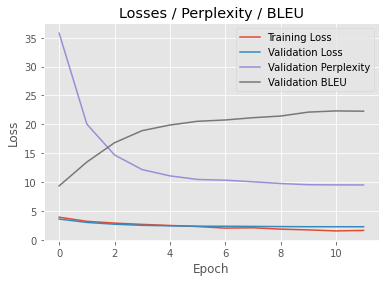

In [13]:
# plot losses and validation accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, hparams.epochs), train_losses, label="Training Loss")
plt.plot(range(0, hparams.epochs), valid_losses, label="Validation Loss")
plt.plot(range(0, hparams.epochs), valid_perplexities, label="Validation Perplexity")
plt.plot(range(0, hparams.epochs), valid_bleus, label="Validation BLEU")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses / Perplexity / BLEU")
plt.show()

In [15]:
print("Qualitative Evaluation: Translating from Vietnamese to English")

expected_tgt_seq = "I like to read books."
print("Expected translation:")
print(expected_tgt_seq)
# From Google Translate
src_seq = "Tôi thích đọc sách kỹ thuật."
print("In Vietnamese (from Google Translate):")
print(src_seq)

translation_out = nmt.utils.translate(
    transformer_translator,
    src_seq,
    iwslt_src_vocab,
    iwslt_tgt_vocab,
    ctx)

print("The English translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I love reading the technology skills I liked to read , I liked reading the book skills that I liked to read , I liked reading the book skills that I liked to read , and I liked to read , I liked to read , I liked to read
